In [1]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.manifold import TSNE

def simulated_data_codes(nn=60, samples=300, case=1, numhub=3, bighub=10, bigwgt=1, disconnected=15, meanval=0, sdval=1, binaryopt=False):
    ssigma = np.zeros((nn, nn))
    np.fill_diagonal(ssigma, 1)

    covx = np.zeros((nn, 2))
    for i in range(nn):
        covx[i, 0] = np.random.uniform()
        covx[i, 1] = np.random.uniform()

    dij = np.zeros((nn, nn))
    for i in range(nn):
        for j in range(nn):
            dij[i, j] = np.sqrt((covx[i, 0] - covx[j, 0]) ** 2 + (covx[i, 1] - covx[j, 1]) ** 2)

    counts = 0
    yyy = bighub
    conx = np.zeros((nn, nn))
    for i in range(numhub):
        tmp = np.argsort(dij[i, :])[:bighub]
        conx[i, tmp] = 1
        conx[tmp, i] = 1

    for xx in range(nn - disconnected, nn):
        for yy in range(nn):
            conx[xx, yy] = 0
            conx[yy, xx] = 0

    np.fill_diagonal(conx, 0)

    temp = np.ones((nn, nn))
    for ii in range(nn):
        for iii in range(ii + 1):
            temp[iii, ii] = 0

    premat = np.random.uniform(0, 1, (nn, nn))
    premat[temp == 0] = 0
    np.fill_diagonal(premat, 1)
    premat[conx != 1] = 0
    premat = premat - premat.T
    premat[(premat > 0) & (premat < 0.5)] -= 1
    np.fill_diagonal(premat, np.abs(premat).sum(axis=1) + 0.5)

    premat1 = np.sqrt(np.outer(np.diag(premat), np.diag(premat)))
    premat = premat / premat1

    covmat = np.linalg.inv(premat)
    eigencov = np.linalg.eig(covmat)

    D = np.zeros((nn, nn))
    np.fill_diagonal(D, np.sqrt(eigencov[0]))

    covmats = eigencov[1] @ D @ eigencov[1].T

    bighubnum = 1
    counts = 0
    simudat = np.zeros((samples, nn))

    for i in range(samples):
        simudat[i] = covmats @ np.random.randn(nn)

    s = simudat.copy()
    haha = simudat.copy()

    if case == 1:
        s[:, :numhub] *= bigwgt
    elif case == 2:
        s[:, :numhub // 2] *= bigwgt
        s[:, numhub:(numhub + ((numhub + 1) // 2))] *= bigwgt
    elif case == 3:
        s[:, (numhub - (numhub // 2)):(numhub + (numhub // 2))] *= bigwgt
    elif case == 4:
        temp = np.random.choice(nn, numhub, replace=False)
        s[:, temp] *= bigwgt
    elif case == 5:
        s[:, np.random.choice(nn, nn // 2, replace=False)] *= bigwgt

    if not binaryopt:
        new_list = {
            "simudata": s,
            "originconx": conx,
            "rawsimudata": haha
        }
    else:
        binary_conx = (conx > meanval).astype(int)
        new_list = {
            "simudata": binary_conx * s,
            "rawsimudata": binary_conx * haha,
            "originconx": binary_conx
        }

    tsne = TSNE(n_components=2, init='random', learning_rate=200.0)
    reduced_data = tsne.fit_transform(new_list["simudata"])

    min_val = np.min(reduced_data, axis=0)
    max_val = np.max(reduced_data, axis=0)

    normalized_data = (reduced_data - min_val) / (max_val - min_val) * 223
    normalized_data = np.round(normalized_data).astype(int)

    image = np.zeros((224, 224))
    point_index_mapping = []

    for idx, point in enumerate(normalized_data):
        x, y = point
        image[y, x] = 1
        point_index_mapping.append((x, y, idx))

    return image, point_index_mapping, new_list["simudata"]


C:\Users\jinnu\anaconda3\Lib\site-packages\numpy\lib\index_tricks.py:916: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val
C:\Users\jinnu\AppData\Local\Temp\ipykernel_143544\3405749552.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  simudat[i] = covmats @ np.random.randn(nn)
C:\Users\jinnu\anaconda3\Lib\site-packages\numpy\lib\index_tricks.py:916: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val
C:\Users\jinnu\AppData\Local\Temp\ipykernel_143544\3405749552.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  simudat[i] = covmats @ np.random.randn(nn)
C:\Users\jinnu\anaconda3\Lib\site-packages\numpy\lib\index_tricks.py:916: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val
C:\Users\jinnu\AppData\Local\Temp\ipykernel_143544\3405749552.py:66: ComplexWarning: Casting comp

관심 영역의 크기: 1222


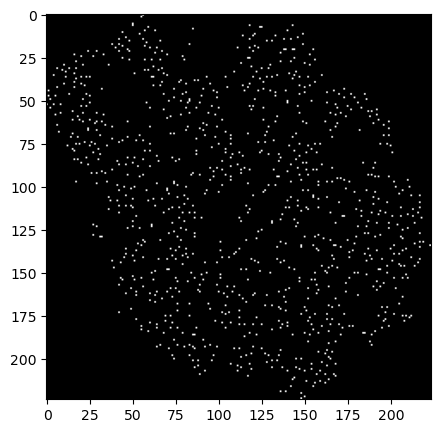

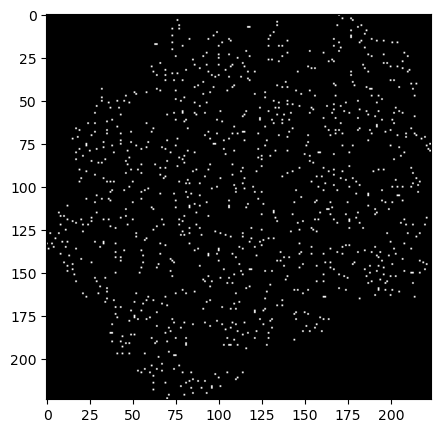

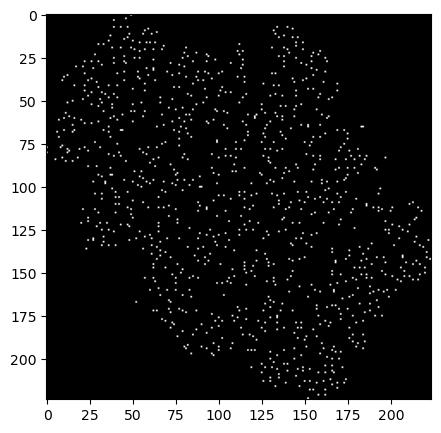

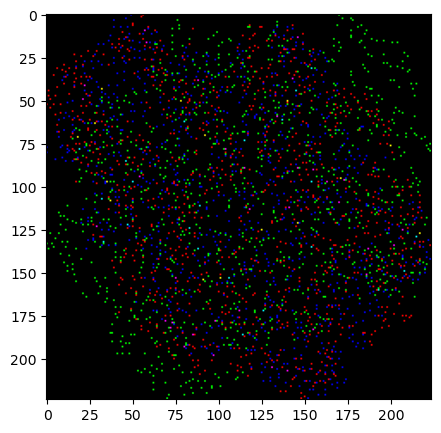

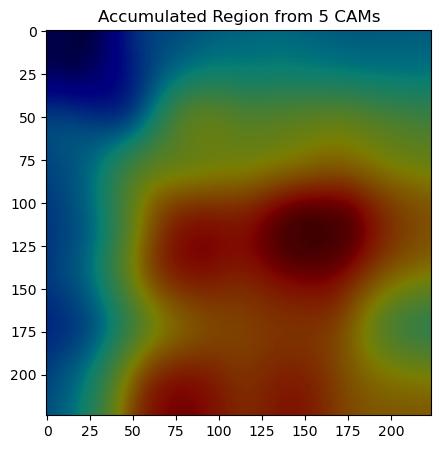

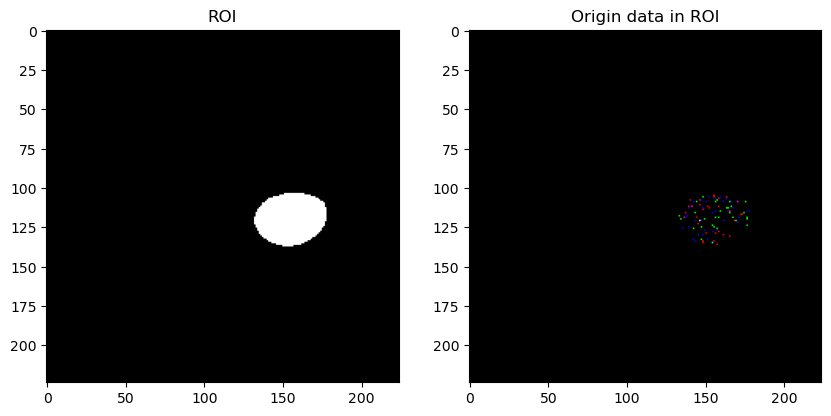

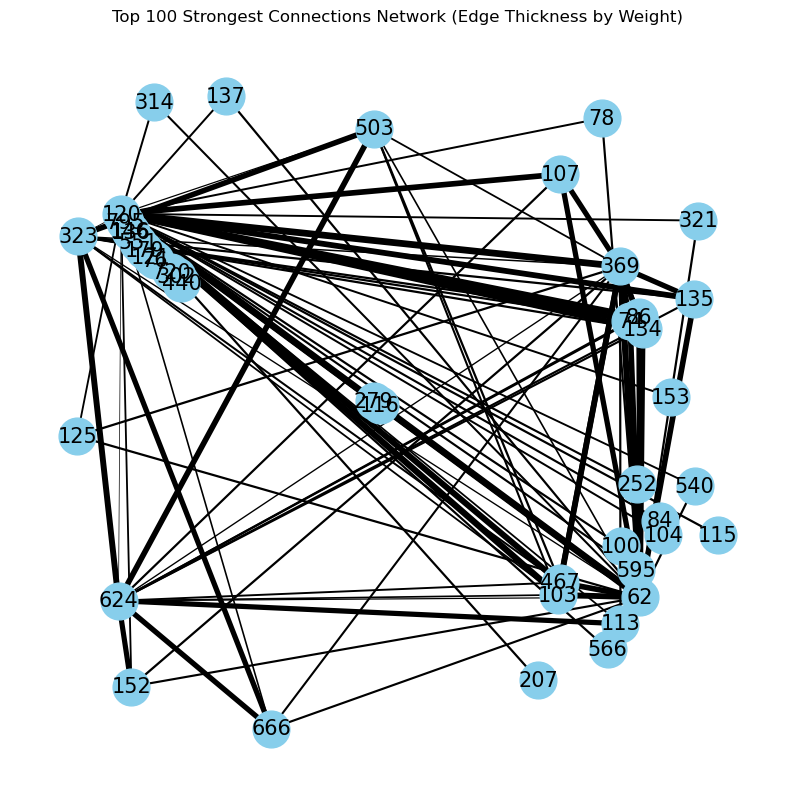

In [3]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import functional as F
import networkx as nx


# 시뮬레이션 결과를 저장할 리스트
simulation_results = []
point_index_mappings = []
origin_data = []



def run_simulation(panel):
    nn = int(nn_entry.get())
    samples = int(samples_entry.get())
    case = int(case_entry.get())
    numhub = int(numhub_entry.get())
    bighub = int(bighub_entry.get())
    bigwgt = float(bigwgt_entry.get())
    disconnected = int(disconnected_entry.get())
    meanval = float(meanval_entry.get())
    sdval = float(sdval_entry.get())
    binaryopt = bool(binaryopt_var.get())

    image, point_index_mapping, data = simulated_data_codes(nn, samples, case, numhub, bighub, bigwgt, disconnected, meanval, sdval, binaryopt)

    # 시뮬레이션 결과 저장
    simulation_results.append(image)
    point_index_mappings.append(point_index_mapping)
    origin_data.append(data)
   
    # 새로운 창 생성
    new_window = tk.Toplevel(root)
    new_window.title(f"Simulated Image {len(simulation_results)}")

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    canvas = FigureCanvasTkAgg(fig, master=new_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

def show_simulation(index):
    if index < 1 or index > len(simulation_results):
        return

    image = simulation_results[index - 1]

    # 새로운 창 생성
    new_window = tk.Toplevel(root)
    new_window.title(f"Simulated Image {index}")

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    canvas = FigureCanvasTkAgg(fig, master=new_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    
    
# CAM 생성 및 시각화 함수
def generate_and_visualize_cam(im):
    im1 = Image.fromarray(im.astype('uint8'), 'RGB')

    # 이미지 전처리
    def preprocess_image(im1):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        return transform(im1).unsqueeze(0)

    # 후크 함수 정의
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    # CAM 계산 함수
    def returnCAM(feature_conv, weight_softmax, class_idx):
        size_upsample = (224, 224)
        bz, nc, h, w = feature_conv.shape
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        return np.array(Image.fromarray(cam_img).resize(size_upsample, Image.LANCZOS))

    # 모델 로드 및 설정
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.eval()
    final_layer = model.layer4
    final_layer.register_forward_hook(hook_feature)

    # 모델의 마지막 컨볼루션 레이어의 가중치 가져오기
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    # 이미지 전처리 및 모델을 통과
    input_batch = preprocess_image(im1)
    output = model(input_batch)

    # 예측된 클래스의 인덱스 얻기
    h_x = F.softmax(output, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    idx = idx.numpy()

    # 선택된 클래스들에 대한 CAM 생성
    CAMs = [returnCAM(features_blobs[0], weight_softmax, class_id) for class_id in idx[:5]]

    # 누적 영역 계산
    accumulated_region = np.mean(CAMs, axis=0)
    accumulated_region = accumulated_region / np.max(accumulated_region)

    # 새로운 창 생성
    cam_window = tk.Toplevel(root)
    cam_window.title("CAM Visualization")

    # 누적 영역을 새로운 창에 시각화
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(im1)
    ax.imshow(accumulated_region, cmap='jet', alpha=0.5)
    ax.set_title('Accumulated Region from 5 CAMs')

    canvas = FigureCanvasTkAgg(fig, master=cam_window)
    canvas.draw()
    canvas.get_tk_widget().pack()
    
    # ROI 버튼 추가 및 클릭 이벤트 연결
    roi_button = tk.Button(cam_window, text="ROI", command=lambda:show_roi(accumulated_region, im))
    roi_button.pack()
    



def show_roi(accumulated_region, rgb_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # 관심 영역 정의
    threshold = 0.95  # 임계값 설정
    roi = accumulated_region > threshold  # 임계값보다 큰 값을 가진 영역을 관심 영역으로 정의

    # 관심 영역 시각화
    ax1.imshow(roi, cmap='gray')
    ax1.set_title('ROI')

    # 관심 영역의 크기 계산
    roi_size = np.sum(roi)
    print(f'관심 영역의 크기: {roi_size}')
    
    
    rgb_image=np.array(rgb_image)
    # 관심 영역에 해당하는 RGB 데이터 추출 및 시각화
    roi_rgb_image = np.zeros_like(rgb_image)  # 초기 RGB 이미지와 같은 크기의 빈 이미지 생성
    for i in range(3):  # 각 RGB 채널에 대해
        roi_rgb_image[:, :, i] = rgb_image[:, :, i] * roi  # 관심 영역에 해당하는 부분만 추출

    # 추출된 관심 영역의 RGB 이미지 시각화
    ax2.imshow(roi_rgb_image)
    ax2.set_title('Origin data in ROI')

    # 새로운 창에 시각화
    roi_window = tk.Toplevel(root)
    roi_window.title("ROI Visualization")

    roi_canvas = FigureCanvasTkAgg(fig, master=roi_window)
    roi_canvas.draw()
    roi_canvas.get_tk_widget().pack()

    # CAM 버튼 추가
    find_index_button = tk.Button(roi_window, text="find_indexes_in_roi", command=lambda:network_analysis(roi))
    find_index_button.pack()
    




def network_analysis(roi):
    indexes_in_roi = []  # 관심 영역 내 포인트들의 인덱스를 저장할 리스트
    for i in range(3):
        for x, y, original_index in point_index_mappings[i]:
            if roi[y, x]:  # 해당 포인트가 관심 영역 내에 있는 경우
                indexes_in_roi.append(original_index)

    # 관심 영역에 있는 포인트들의 인덱스 찾기
    indexes_in_roi1 = indexes_in_roi[0]
    indexes_in_roi2 =indexes_in_roi[1]
    indexes_in_roi3 = indexes_in_roi[2]

    # indexes_in_roi에 해당하는 data 슬라이싱
    sliced_data1 = origin_data[0][indexes_in_roi1]
    sliced_data2 = origin_data[1][indexes_in_roi2]
    sliced_data3 = origin_data[2][indexes_in_roi3]

    combined_matrix = np.vstack((sliced_data1, sliced_data2, sliced_data3))
    # 각 칼럼의 합 계산
    column_sums = np.sum(combined_matrix, axis=0)

    # 칼럼의 합이 0이 아닌 칼럼의 인덱스 찾기
    non_zero_columns = np.where(column_sums != 0)[0]

    # 칼럼의 합이 0이 아닌 칼럼만 선택하여 새로운 행렬 생성
    filtered_matrix = combined_matrix[:, non_zero_columns]

    cov_matrix = np.cov(filtered_matrix, rowvar=False)  # rowvar=False로 설정하여 칼럼 기준으로 계산

    #자기 자신과의 관계를 제외하기 위해 대각선 원소를 0으로 설정
    np.fill_diagonal(cov_matrix, 0)

    # 상위 100개의 가장 강한 연결을 찾기
    indices = np.abs(cov_matrix).ravel().argsort()[-200:]
    rows, cols = np.unravel_index(indices, cov_matrix.shape)

    # 네트워크 생성
    G = nx.Graph()

    # 에지 추가
    for i, j in zip(rows, cols):
        weight = cov_matrix[i, j]
        if not G.has_edge(i, j) and weight != 0:
            G.add_edge(i, j, weight=weight)

    # 에지의 두께를 가중치에 비례하도록 설정
    edge_widths = np.array([G[u][v]['weight'] for u, v in G.edges()])

    # 에지 두께 정규화 (예: 에지 두께를 0.5에서 5 사이로 조정)
    edge_widths_normalized = (edge_widths - edge_widths.min()) / (edge_widths.max() - edge_widths.min()) * 4.5 + 0.5


     # 네트워크 시각화
    fig, ax = plt.subplots(figsize=(10, 10))
    pos = nx.spring_layout(G)  # 노드의 위치 결정
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', width=edge_widths_normalized, linewidths=1, font_size=15, ax=ax)
    ax.set_title("Top 100 Strongest Connections Network (Edge Thickness by Weight)")

    # Tkinter 창 생성
    nt_window = tk.Tk()
    nt_window.title("Network Visualization")

    canvas = FigureCanvasTkAgg(fig, master=nt_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    
    
    
    
    
    



# RGB 이미지 생성 함수
def make_rgb_image():
    if len(simulation_results) < 3:
        return

    image1 = simulation_results[0]
    image2 = simulation_results[1]
    image3 = simulation_results[2]

    # np.stack을 사용하여 RGB 이미지 생성
    rgb_image = np.stack((image1, image2, image3), axis=-1)

    # 새로운 창 생성
    new_window = tk.Toplevel(root)
    new_window.title("RGB Image")

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rgb_image)
    canvas = FigureCanvasTkAgg(fig, master=new_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # CAM 버튼 추가
    cam_button = tk.Button(new_window, text="Generate CAM", command=lambda: generate_and_visualize_cam(rgb_image))
    cam_button.pack()

    
    

def open_simulation_window():
    sim_window = tk.Toplevel(root)
    sim_window.title("Run Simulation")

    # 화면 해상도
    screen_width = sim_window.winfo_screenwidth()
    screen_height = sim_window.winfo_screenheight()
    
    # 창의 시작 크기 설정 
    window_width = 250
    window_height = 600
    sim_window.geometry(f"{window_width}x{window_height}")
    
    # 중앙에 위치시킬 때의 좌표 계산
    position_top = int(screen_height / 2 - window_height / 2)
    position_right = int(screen_width / 2 - window_width / 2)
    
    # 창의 위치 설정
    sim_window.geometry(f"+{position_right}+{position_top}")

    
    # Define parameter entries
    nn_label = ttk.Label(sim_window, text="nn:")
    nn_label.grid(row=0, column=0, padx=5, pady=5)
    global nn_entry
    nn_entry = ttk.Entry(sim_window)
    nn_entry.grid(row=0, column=1, padx=5, pady=5)

    samples_label = ttk.Label(sim_window, text="samples:")
    samples_label.grid(row=1, column=0, padx=5, pady=5)
    global samples_entry
    samples_entry = ttk.Entry(sim_window)
    samples_entry.grid(row=1, column=1, padx=5, pady=5)

    case_label = ttk.Label(sim_window, text="case:")
    case_label.grid(row=2, column=0, padx=5, pady=5)
    global case_entry
    case_entry = ttk.Entry(sim_window)
    case_entry.grid(row=2, column=1, padx=5, pady=5)

    numhub_label = ttk.Label(sim_window, text="numhub:")
    numhub_label.grid(row=3, column=0, padx=5, pady=5)
    global numhub_entry
    numhub_entry = ttk.Entry(sim_window)
    numhub_entry.grid(row=3, column=1, padx=5, pady=5)

    bighub_label = ttk.Label(sim_window, text="bighub:")
    bighub_label.grid(row=4, column=0, padx=5, pady=5)
    global bighub_entry
    bighub_entry = ttk.Entry(sim_window)
    bighub_entry.grid(row=4, column=1, padx=5, pady=5)

    bigwgt_label = ttk.Label(sim_window, text="bigwgt:")
    bigwgt_label.grid(row=5, column=0, padx=5, pady=5)
    global bigwgt_entry
    bigwgt_entry = ttk.Entry(sim_window)
    bigwgt_entry.grid(row=5, column=1, padx=5, pady=5)

    disconnected_label = ttk.Label(sim_window, text="disconnected:")
    disconnected_label.grid(row=6, column=0, padx=5, pady=5)
    global disconnected_entry
    disconnected_entry = ttk.Entry(sim_window)
    disconnected_entry.grid(row=6, column=1, padx=5, pady=5)

    meanval_label = ttk.Label(sim_window, text="meanval:")
    meanval_label.grid(row=7, column=0, padx=5, pady=5)
    global meanval_entry
    meanval_entry = ttk.Entry(sim_window)
    meanval_entry.grid(row=7, column=1, padx=5, pady=5)

    sdval_label = ttk.Label(sim_window, text="sdval:")
    sdval_label.grid(row=8, column=0, padx=5, pady=5)
    global sdval_entry
    sdval_entry = ttk.Entry(sim_window)
    sdval_entry.grid(row=8, column=1, padx=5, pady=5)

    global binaryopt_var
    binaryopt_var = tk.IntVar()
    binaryopt_check = ttk.Checkbutton(sim_window, text="Binary Option", variable=binaryopt_var)
    binaryopt_check.grid(row=9, columnspan=2, padx=5, pady=5)

    # Run button
    run_button = ttk.Button(sim_window, text="Run Simulation", command=lambda : run_simulation(panels_frame))
    run_button.grid(row=10, columnspan=2, padx=5, pady=5)

    # Show Simulation buttons
    for i in range(3):
        show_button = ttk.Button(sim_window, text=f"Show Simulation {i+1}", command=lambda i=i: show_simulation(i+1))
        show_button.grid(row=11 + i, column=0, columnspan=2, padx=5, pady=5)

    # Make RGB Image button
    rgb_button = ttk.Button(sim_window, text="Make RGB Image", command=make_rgb_image)
    rgb_button.grid(row=14, column=0, columnspan=2, padx=5, pady=5)






root = tk.Tk()
root.title("Simulated Data Viewer")

# 창의 시작 크기 설정 (예: 800x600)
root.geometry("800x400")

# 화면 해상도
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

# update_idletasks() 함수를 호출하여 변경 사항을 즉시 반영
root.update_idletasks()

# Tkinter 창의 실제 크기
window_width = root.winfo_width()
window_height = root.winfo_height()

# 중앙에 위치시킬 때의 좌표 계산
position_top = int(screen_height / 2 - window_height / 2)
position_right = int(screen_width / 2 - window_width / 2)

# 창의 위치 설정
root.geometry("+{}+{}".format(position_right, position_top))

# Create the main frame
main_frame = ttk.Frame(root)
main_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

# Create frames for the parameter input and panels
input_frame = ttk.Frame(main_frame, height=100)  # 높이를 설정
input_frame.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)
input_frame.pack_propagate(False)  # 자식 위젯의 크기에 따라 프레임 크기가 변하지 않도록 설정

panels_frame = ttk.Frame(main_frame)
panels_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

# 스타일 설정
style = ttk.Style()
style.configure("LargeButton.TButton", font=("Helvetica", 15,"bold"))  # 폰트 크기를 20으로 설정

# Open simulation window button
open_sim_button = ttk.Button(input_frame, text="Multi-Omics Data Analysis", command=open_simulation_window, style="LargeButton.TButton")
open_sim_button.place(relx=0.5, rely=0.5, anchor=tk.CENTER, width=300, height=80)  # 버튼 크기를 더 크게 조정


# Additional buttons
button_frame = ttk.Frame(main_frame)
button_frame.pack(side=tk.BOTTOM, pady=10)

ad3_button = ttk.Button(button_frame, text="AD3", style="TButton")
ad3_button.grid(row=0, column=0, padx=5, pady=10, ipadx=20, ipady=10)

ai_drug_button = ttk.Button(button_frame, text="AI Drug", style="TButton")
ai_drug_button.grid(row=0, column=1, padx=5, pady=10, ipadx=20, ipady=10)

ceek_button = ttk.Button(button_frame, text="CEEK", style="TButton")
ceek_button.grid(row=0, column=2, padx=5, pady=10, ipadx=20, ipady=10)

Md = ttk.Button(button_frame, text="Motif Dr", style="TButton")
Md.grid(row=0, column=3, padx=5, pady=10, ipadx=20, ipady=10)

ReBADD = ttk.Button(button_frame, text="ReBADD Pro", style="TButton")
ReBADD.grid(row=1, column=0, padx=5, pady=10, ipadx=20, ipady=10)

WPLite = ttk.Button(button_frame, text="WPLite", style="TButton")
WPLite.grid(row=1, column=1, padx=5, pady=10, ipadx=20, ipady=10)

OncoNect = ttk.Button(button_frame, text="OncoNect", style="TButton")
OncoNect.grid(row=1, column=2, padx=5, pady=10, ipadx=20, ipady=10)

CSK = ttk.Button(button_frame, text="CSK Studio", style="TButton")
CSK.grid(row=1, column=3, padx=5, pady=10, ipadx=20, ipady=10)

MiLearn = ttk.Button(button_frame, text="MiLearn", style="TButton")
MiLearn.grid(row=2, column=0, padx=5, pady=10, ipadx=20, ipady=10)

Synbi = ttk.Button(button_frame, text="Synbi", style="TButton")
Synbi.grid(row=2, column=1, padx=5, pady=10, ipadx=20, ipady=10)

Smart_Pv = ttk.Button(button_frame, text="Smart Pv", style="TButton")
Smart_Pv.grid(row=2, column=2, padx=5, pady=10, ipadx=20, ipady=10)

more = ttk.Button(button_frame, text="More Info", style="TButton")
more.grid(row=2, column=3, padx=5, pady=10, ipadx=20, ipady=10)



root.mainloop()